<div align='center'>
<img src="https://data.seattle.gov/api/assets/82167BD8-353E-4232-96AD-72F5BF83F1D3?Official-Seattle-Logo-White__1_.png" alt="Seattle logo">  
</div>

---

<div align='center'> Projet 4 :Anticipez les besoins en consommation de bâtiments </div>
<div align='center'> Notebook: Modelisation de la prédiction de l'emission de CO²
</div>


# MISSION

La ville de Seattle nous a confié une mission cruciale pour atteindre son objectif de ville neutre en émissions de carbone en 2050 : **prédire les émissions de CO² et la consommation d'énergie des bâtiments non résidentiels**, en évitant les recours à des relevés onéreux.   
En s'appuyant sur les données collectées avec rigueur en 2016, notre équipe s'est engagée dans la **conception d'un modèle prédictif** qui exploite les caractéristiques structurelles des bâtiments.  

Ce rapport détaille **les méthodes et les résultats** de notre étude sur la **prédiction de l'émission a effet de serre** des bâtiments. Après une analyse exploratoire approfondie, ce document se concentre sur l'évaluation de divers modèles prédictifs et explore l'influence de l'ENERGY STAR Score sur la précision de ces prédictions.

# PREPARATION DES DONNEES AU ML

In [1]:
# Importation des bibliothèques pour l'analyse de données
import numpy as np
import pandas as pd
import time

# Importation des bibliothèques pour la visualisation de données
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Importation des bibliothèques pour le prétraitement des données
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_selection import SelectFromModel

# Importation des modèles de machine learning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import (RandomForestRegressor, BaggingRegressor,AdaBoostRegressor, StackingRegressor)
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Importation des outils pour la sélection de modèles et l'évaluation
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV,
    learning_curve
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Importation des distributions statistiques pour la recherche aléatoire
from scipy.stats import randint, uniform, reciprocal, expon, loguniform

# Importation des outils pour la création de pipelines
from sklearn.pipeline import Pipeline, make_pipeline

In [2]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 9.0 MB/s eta 0:00:00


In [3]:
# Importation de SHAP pour la visualisation de données
import shap

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Chargement du dataset
chemin_fichier = '/content/drive/MyDrive/Data/df_model_energy_filtred.csv'

# Chargement des données
df_model= pd.read_csv(chemin_fichier)
#Ajustement d'affichage
pd.set_option('display.max_columns', 50)

In [6]:
df_model.describe()

,PrimaryPropertyType_Education,PrimaryPropertyType_Food Service,PrimaryPropertyType_Healthcare,PrimaryPropertyType_Hospitality,PrimaryPropertyType_Mixed Use,PrimaryPropertyType_Office,PrimaryPropertyType_Other,PrimaryPropertyType_Religious,PrimaryPropertyType_Retail,PrimaryPropertyType_Storage,Neighborhood_BALLARD,Neighborhood_CENTRAL,Neighborhood_DELRIDGE,Neighborhood_DOWNTOWN,Neighborhood_EAST,Neighborhood_GREATER DUWAMISH,Neighborhood_LAKE UNION,Neighborhood_MAGNOLIA / QUEEN ANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,log_SiteEnergyUse(kBtu),log_TotalGHGEmissions,log_NumberofBuildings,log_NumberOfActivities,log_PropertyGFATotal,log_AverageFloorArea,log_Parking_ratio,log_LargestPropertyUseTypeGFA_ratio,Latitude,Longitude,ENERGYSTARScore,BuildingAge,ResidentialSection
count,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,916.000000,1328.000000,1328.000000
mean,0.040663,0.006777,0.052711,0.054217,0.064759,0.320783,0.124247,0.050452,0.089608,0.195783,0.041416,0.029367,0.024849,0.230422,0.073042,0.222892,0.097139,0.088855,0.035392,0.067771,0.048193,0.018825,0.021837,14.877344,3.924721,0.712749,1.004047,11.031048,10.028300,0.748578,4.419870,47.615134,-122.333987,63.911572,55.204819,0.152108
std,0.197582,0.082075,0.223540,0.226530,0.246193,0.466953,0.329987,0.218958,0.285728,0.396952,0.199325,0.168898,0.155725,0.421261,0.260304,0.416343,0.296258,0.284642,0.184837,0.251447,0.214254,0.135959,0.146207,1.336081,1.452132,0.135752,0.331931,0.943284,0.733725,1.416320,0.315654,0.046618,0.022939,29.105383,32.590079,0.359261
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.729723,0.113329,0.693147,0.693147,9.698982,8.080785,0.000000,2.978077,47.509590,-122.411820,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.967799,2.976932,0.693147,0.693147,10.272401,9.469587,0.000000,4.239777,47.586028,-122.342635,44.000000,29.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.757077,3.859993,0.693147,1.098612,10.762939,10.004707,0.000000,4.555665,47.612139,-122.333280,71.000000,51.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.757325,4.886280,0.693147,1.098612,11.543864,10.482658,0.000000,4.615121,47.647250,-122.323778,89.000000,87.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,19.495993,9.418018,2.302585,2.484907,14.484478,13.180708,4.505350,6.467202,47.733870,-122.262770,100.000000,116.000000,1.000000


In [7]:
# Sélection des caractéristiques et définition de la variable cible pour la prédiction d'emission de CO²
X = df_model.drop(['log_SiteEnergyUse(kBtu)','ENERGYSTARScore','log_TotalGHGEmissions'], axis=1)
y = df_model['log_TotalGHGEmissions'].copy()

In [8]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('Train set :', X_train.shape)
print('Test set :', X_test.shape)

Train set : (929, 33)
Test set : (399, 33)


# REGRESSION LINEAIRE

In [9]:
lin_reg = Pipeline([
    ('linear_regression', LinearRegression())
])

In [10]:
# Entraînement du modèle
lr_start_time = time.time()
lin_reg.fit(X_train, y_train)
lr_end_time = time.time()

lin_reg_predict = lin_reg.predict(X_train)

In [11]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", lin_reg_predict[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [3.84 2.46 4.33 3.25 3.11]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [12]:
# Calcul des métriques d'évaluation
lin_reg_rmse = mean_squared_error(y_train, lin_reg_predict, squared=False)
lin_reg_mae = mean_absolute_error(y_train, lin_reg_predict)
lin_reg_r2 = r2_score(y_train, lin_reg_predict)

print('Score RMSE:', lin_reg_rmse.round(2))
print('Score MAE:', lin_reg_mae.round(2))
print('Coefficient de détermination R²:', lin_reg_r2.round(2))

Score RMSE: 0.99
Score MAE: 0.79
Coefficient de détermination R²: 0.54


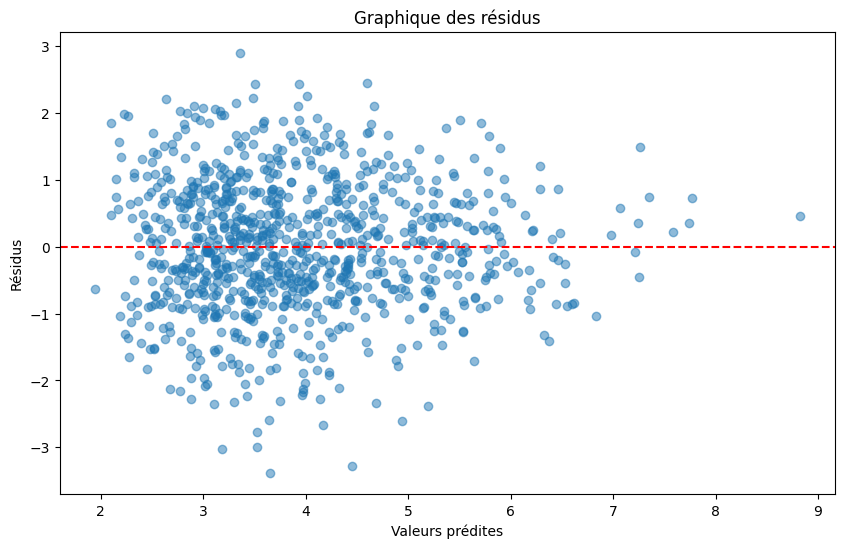

In [13]:
# Graphique des résidus
residuals = y_train - lin_reg_predict

plt.figure(figsize=(10, 6))
plt.scatter(lin_reg_predict, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [14]:
# Validation croisée
cv_scores = cross_val_score(lin_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [1.10338607 1.01831701 0.85402965 1.06195752 1.23548515 1.01832781
 0.9256097  0.95103312 1.00102003 1.10165644]
Moyenne des scores de la validation croisée (RMSE): 1.0270822499225687


In [15]:
# Prédiction sur l'ensemble de test
y_test_pred = lin_reg.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 0.9967415201794431
Score MAE sur l'ensemble de test: 0.785921584135055
Coefficient de détermination R² sur l'ensemble de test: 0.5252036728250207


In [16]:
# Recherche des meilleurs hyperparamètres
param_distributions = {
    'linear_regression__fit_intercept': [True, False]
}

random_search = RandomizedSearchCV(
    lin_reg,
    param_distributions=param_distributions,
    n_iter=2,
    cv=5,
    scoring='r2',
    refit=True,
    random_state=42
)

random_search.fit(X_train, y_train)

print(f'Meilleurs paramètres: {random_search.best_params_}')

Meilleurs paramètres: {'linear_regression__fit_intercept': False}


In [17]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search.best_estimator_
y_test_pred = best_model.predict(X_test)

test_rmse_lr = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae_lr = mean_absolute_error(y_test, y_test_pred)
test_r2_lr = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_lr}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_lr}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_lr}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 0.996728634907415
Score MAE sur l'ensemble de test avec le meilleur modèle: 0.7858899550133572
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: 0.5252159485056571


## Avec StandardScaler

In [18]:
lin_reg_with_scaler = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
])

In [19]:
# Entraînement du modèle
lr_scaler_start_time = time.time()
lin_reg_with_scaler.fit(X_train, y_train)
lr_scaler_end_time = time.time()

lin_reg_predict_with_scaler = lin_reg_with_scaler.predict(X_train)

In [20]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", lin_reg_predict_with_scaler[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [3.8  2.46 4.37 3.25 3.17]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [21]:
# Calcul des métriques d'évaluation
lin_reg_scaler_rmse = mean_squared_error(y_train, lin_reg_predict_with_scaler, squared=False)
lin_reg_scaler_mae = mean_absolute_error(y_train, lin_reg_predict_with_scaler)
lin_reg_scaler_r2 = r2_score(y_train, lin_reg_predict_with_scaler)

print('Score RMSE:', lin_reg_scaler_rmse.round(2))
print('Score MAE:', lin_reg_scaler_mae.round(2))
print('Coefficient de détermination R²:', lin_reg_scaler_r2.round(2))

Score RMSE: 0.99
Score MAE: 0.8
Coefficient de détermination R²: 0.53


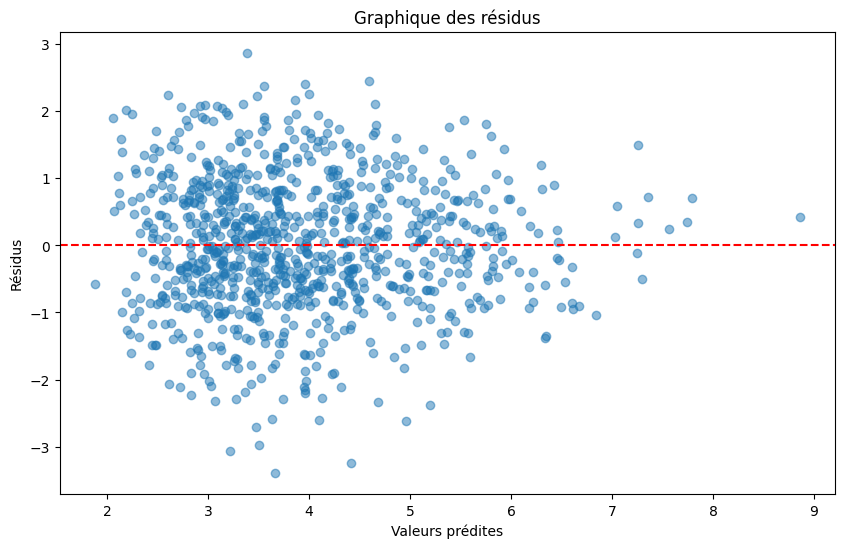

In [22]:
# Graphique des résidus
residuals = y_train - lin_reg_predict_with_scaler

plt.figure(figsize=(10, 6))
plt.scatter(lin_reg_predict_with_scaler, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [23]:
# Validation croisée
cv_scores = cross_val_score(lin_reg_with_scaler, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [1.09875436 1.01592243 0.86423634 1.05459172 1.24500663 1.02098548
 0.93729847 0.95414493 1.00215791 1.10389153]
Moyenne des scores de la validation croisée (RMSE): 1.0296989807775314


In [24]:
# Prédiction sur l'ensemble de test
y_test_pred_scaler = lin_reg_with_scaler.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred_scaler, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred_scaler)
test_r2 = r2_score(y_test, y_test_pred_scaler)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 0.9990478747815605
Score MAE sur l'ensemble de test: 0.7899767847944023
Coefficient de détermination R² sur l'ensemble de test: 0.5230038736081465


In [25]:
# Recherche des meilleurs hyperparamètres
param_distributions = {
    'linear_regression__fit_intercept': [True, False]
}

random_search = RandomizedSearchCV(
    lin_reg_with_scaler,
    param_distributions=param_distributions,
    n_iter=2,
    cv=5,
    scoring='r2',
    refit=True,
    random_state=42
)

random_search.fit(X_train, y_train)

print(f'Meilleurs paramètres: {random_search.best_params_}')

Meilleurs paramètres: {'linear_regression__fit_intercept': True}


In [26]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search.best_estimator_
y_test_pred = best_model.predict(X_test)

test_rmse_lr_scaler = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae_lr_scaler = mean_absolute_error(y_test, y_test_pred)
test_r2_lr_scaler = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_lr_scaler}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_lr_scaler}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_lr_scaler}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 0.9990478747815605
Score MAE sur l'ensemble de test avec le meilleur modèle: 0.7899767847944023
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: 0.5230038736081465


# LASSO

In [27]:
lasso_reg = Pipeline([
    ('Lasso', Lasso(random_state=42))
])

In [28]:
# Entraînement du modèle
lasso_start_time = time.time()
lasso_reg.fit(X_train, y_train)
lasso_end_time = time.time()

lasso_reg_predict = lasso_reg.predict(X_train)

In [29]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", lasso_reg_predict[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [3.93 3.74 3.91 3.63 3.98]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [30]:
# Calcul des métriques d'évaluation
lasso_reg_rmse = mean_squared_error(y_train, lasso_reg_predict, squared=False)
lasso_reg_mae = mean_absolute_error(y_train, lasso_reg_predict)
lasso_reg_r2 = r2_score(y_train, lasso_reg_predict)

print('Score RMSE:', lasso_reg_rmse.round(2))
print('Score MAE:', lasso_reg_mae.round(2))
print('Coefficient de détermination R²:', lasso_reg_r2.round(2))

Score RMSE: 1.44
Score MAE: 1.15
Coefficient de détermination R²: 0.02


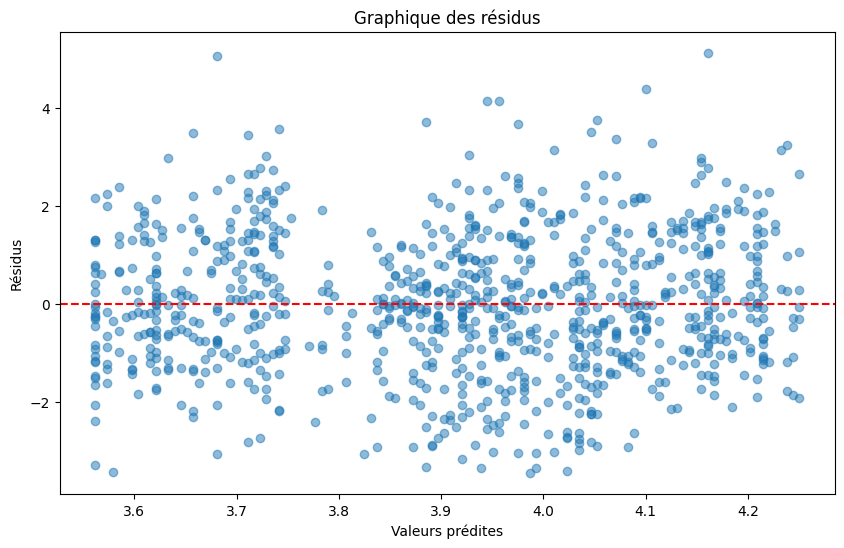

In [31]:
# Graphique des résidus
residuals = y_train - lasso_reg_predict

plt.figure(figsize=(10, 6))
plt.scatter(lasso_reg_predict, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [32]:
# Validation croisée
cv_scores = cross_val_score(lasso_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [1.49267789 1.45854581 1.24560482 1.48299479 1.50373083 1.62476526
 1.28986706 1.36054219 1.53887369 1.34566016]
Moyenne des scores de la validation croisée (RMSE): 1.434326250804244


In [33]:
# Prédiction sur l'ensemble de test
y_test_pred = lasso_reg.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 1.419786571685408
Score MAE sur l'ensemble de test: 1.0956346927469174
Coefficient de détermination R² sur l'ensemble de test: 0.0366405093320642


In [34]:
# Recherche des meilleurs hyperparamètres
param_distributions_lasso = {
    'Lasso__alpha': uniform(0.001, 100),
    'Lasso__max_iter': randint(1000, 10000),
    'Lasso__fit_intercept': [True, False]
}

n_iter_search = 10

random_search_lasso = RandomizedSearchCV(
    lasso_reg,
    param_distributions=param_distributions_lasso,
    n_iter=n_iter_search,
    cv=5,
    scoring='r2',
    refit=True,
    random_state=42
)

random_search_lasso.fit(X_train, y_train)

print(f'Meilleurs paramètres pour Lasso: {random_search_lasso.best_params_}')

Meilleurs paramètres pour Lasso: {'Lasso__alpha': 0.07887658410143283, 'Lasso__fit_intercept': False, 'Lasso__max_iter': 7420}


In [35]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search_lasso.best_estimator_
y_test_pred = best_model.predict(X_test)

test_rmse_lasso = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae_lasso = mean_absolute_error(y_test, y_test_pred)
test_r2_lasso = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_lasso}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_lasso}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_lasso}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 1.1117317859563234
Score MAE sur l'ensemble de test avec le meilleur modèle: 0.8922041936750703
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: 0.4093335582279618


## Avec StandardScaler

In [36]:
lasso_reg_with_scaler = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=42))
])

In [37]:
# Entraînement du modèle
lasso_scaler_start_time = time.time()
lasso_reg_with_scaler.fit(X_train, y_train)
lasso_scaler_end_time = time.time()

lasso_reg_predict_with_scaler = lasso_reg_with_scaler.predict(X_train)

In [38]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", lasso_reg_predict_with_scaler[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [3.92 3.92 3.92 3.92 3.92]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [39]:
# Calcul des métriques d'évaluation
lasso_reg_scaler_rmse = mean_squared_error(y_train, lasso_reg_predict, squared=False)
lasso_reg_scaler_mae = mean_absolute_error(y_train, lasso_reg_predict)
lasso_reg_scaler_r2 = r2_score(y_train, lasso_reg_predict)

print('Score RMSE:', lasso_reg_scaler_rmse.round(2))
print('Score MAE:', lasso_reg_scaler_mae.round(2))
print('Coefficient de détermination R²:', lasso_reg_scaler_r2.round(2))

Score RMSE: 1.44
Score MAE: 1.15
Coefficient de détermination R²: 0.02


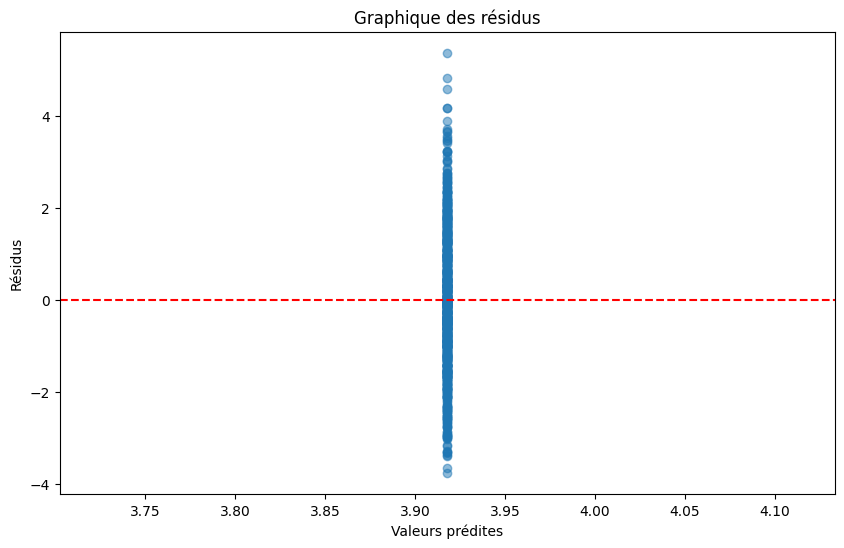

In [40]:
# Graphique des résidus
residuals = y_train - lasso_reg_predict_with_scaler

plt.figure(figsize=(10, 6))
plt.scatter(lasso_reg_predict_with_scaler, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [41]:
# Validation croisée
cv_scores = cross_val_score(lasso_reg_with_scaler, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [1.4943722  1.46474745 1.27173253 1.51103523 1.51622931 1.63302779
 1.29052502 1.36746121 1.56956858 1.3909405 ]
Moyenne des scores de la validation croisée (RMSE): 1.4509639823214449


In [42]:
# Prédiction sur l'ensemble de test
y_test_pred_scaler = lasso_reg_with_scaler.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred_scaler, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred_scaler)
test_r2 = r2_score(y_test, y_test_pred_scaler)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 1.4467180657193968
Score MAE sur l'ensemble de test: 1.113083196796774
Coefficient de détermination R² sur l'ensemble de test: -0.0002534569957335364


In [43]:
# Recherche des meilleurs hyperparamètres
param_distributions_lasso = {
    'lasso__alpha': uniform(0.001, 100),
    'lasso__max_iter': randint(1000, 10000),
    'lasso__fit_intercept': [True, False]
}

n_iter_search = 10

random_search_lasso = RandomizedSearchCV(
    lasso_reg_with_scaler,
    param_distributions=param_distributions_lasso,
    n_iter=n_iter_search,
    cv=5,
    scoring='r2',
    refit=True,
    random_state=42
)

random_search_lasso.fit(X_train, y_train)

print(f'Meilleurs paramètres pour Lasso: {random_search_lasso.best_params_}')

Meilleurs paramètres pour Lasso: {'lasso__alpha': 37.455011884736244, 'lasso__fit_intercept': True, 'lasso__max_iter': 6390}


In [44]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search_lasso.best_estimator_
y_test_pred_scaler = best_model.predict(X_test)

test_rmse_scaler_lasso = mean_squared_error(y_test, y_test_pred_scaler, squared=False)
test_mae_scaler_lasso = mean_absolute_error(y_test, y_test_pred_scaler)
test_r2_scaler_lasso = r2_score(y_test, y_test_pred_scaler)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_scaler_lasso}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_scaler_lasso}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_scaler_lasso}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 1.4467180657193968
Score MAE sur l'ensemble de test avec le meilleur modèle: 1.113083196796774
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: -0.0002534569957335364


# RIDGE

In [45]:
ridge_reg = Pipeline(steps=[
    ('ridge_regressor', Ridge())
])

In [46]:
# Entraînement du modèle
ridge_start_time = time.time()
ridge_reg.fit(X_train, y_train)
ridge_end_time = time.time()

ridge_reg_predict = ridge_reg.predict(X_train)

In [47]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", ridge_reg_predict[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [3.82 2.45 4.33 3.23 3.09]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [48]:
# Calcul des métriques d'évaluation
ridge_reg_rmse = mean_squared_error(y_train, ridge_reg_predict, squared=False)
ridge_reg_mae = mean_absolute_error(y_train, ridge_reg_predict)
ridge_reg_r2 = r2_score(y_train, ridge_reg_predict)

print('Score RMSE:', ridge_reg_rmse.round(2))
print('Score MAE:', ridge_reg_mae.round(2))
print('Coefficient de détermination R²:', ridge_reg_r2.round(2))

Score RMSE: 0.99
Score MAE: 0.79
Coefficient de détermination R²: 0.53


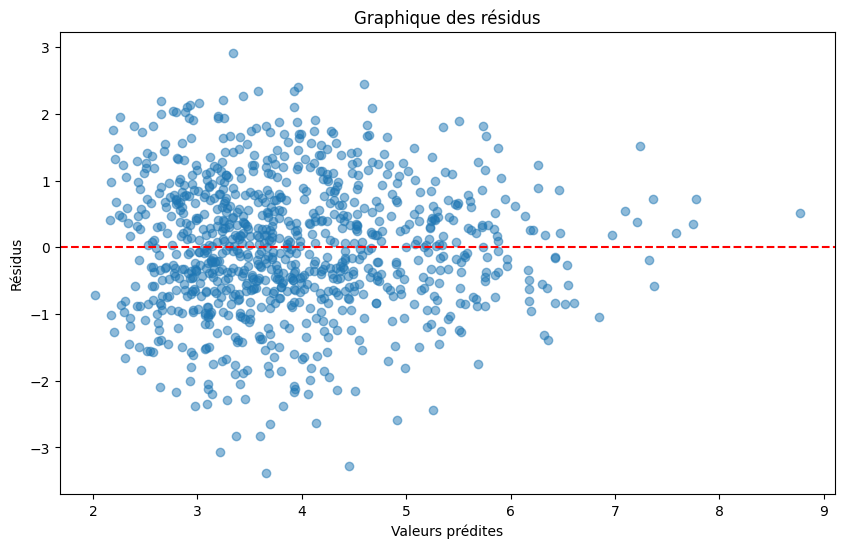

In [49]:
# Graphique des résidus
residuals = y_train - ridge_reg_predict

plt.figure(figsize=(10, 6))
plt.scatter(ridge_reg_predict, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [50]:
# Validation croisée
cv_scores = cross_val_score(ridge_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [1.1029975  0.98535411 0.85562146 1.06642172 1.22805461 1.00674299
 0.93480276 0.9531322  1.00712056 1.11121212]
Moyenne des scores de la validation croisée (RMSE): 1.0251460035481994


In [51]:
# Prédiction sur l'ensemble de test
y_test_pred = ridge_reg.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 0.998991823844968
Score MAE sur l'ensemble de test: 0.787737364457576
Coefficient de détermination R² sur l'ensemble de test: 0.5230573952266893


In [52]:
# Recherche des meilleurs hyperparamètres
param_distributions_ridge = {
    'ridge_regressor__alpha': loguniform(0.001, 100),
    'ridge_regressor__fit_intercept': [True, False],
    'ridge_regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'ridge_regressor__max_iter': [10000, 20000]
}

n_iter_search = 10

random_search_ridge = RandomizedSearchCV(
    ridge_reg,
    param_distributions=param_distributions_ridge,
    n_iter=n_iter_search,
    cv=5,
    scoring='r2',
    refit=True,
    random_state=42
)

random_search_ridge.fit(X_train, y_train)

print(f'Meilleurs paramètres pour Ridge: {random_search_ridge.best_params_}')

Meilleurs paramètres pour Ridge: {'ridge_regressor__alpha': 7.915074397656218, 'ridge_regressor__fit_intercept': True, 'ridge_regressor__max_iter': 10000, 'ridge_regressor__solver': 'svd'}


In [53]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search_ridge.best_estimator_
y_test_pred = best_model.predict(X_test)

test_rmse_ridge = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae_ridge = mean_absolute_error(y_test, y_test_pred)
test_r2_ridge = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_ridge}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_ridge}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_ridge}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 1.0057636261141603
Score MAE sur l'ensemble de test avec le meilleur modèle: 0.7949583346692731
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: 0.5165694388218527


## Avec StandardScaler

In [54]:
ridge_reg_with_scaler = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('ridge_regressor', Ridge())
])

In [55]:
# Entraînement du modèle
ridge_scaler_start_time = time.time()
ridge_reg_with_scaler.fit(X_train, y_train)
ridge_scaler_end_time = time.time()

ridge_reg_predict_with_scaler = ridge_reg_with_scaler.predict(X_train)

In [56]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", ridge_reg_predict_with_scaler[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [3.84 2.46 4.33 3.25 3.11]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [57]:
# Calcul des métriques d'évaluation
ridge_reg_scaler_rmse = mean_squared_error(y_train, ridge_reg_predict_with_scaler, squared=False)
ridge_reg_scaler_mae = mean_absolute_error(y_train, ridge_reg_predict_with_scaler)
ridge_reg_scaler_r2 = r2_score(y_train, ridge_reg_predict_with_scaler)

print('Score RMSE:', ridge_reg_scaler_rmse.round(2))
print('Score MAE:', ridge_reg_scaler_mae.round(2))
print('Coefficient de détermination R²:', ridge_reg_scaler_r2.round(2))

Score RMSE: 0.99
Score MAE: 0.79
Coefficient de détermination R²: 0.54


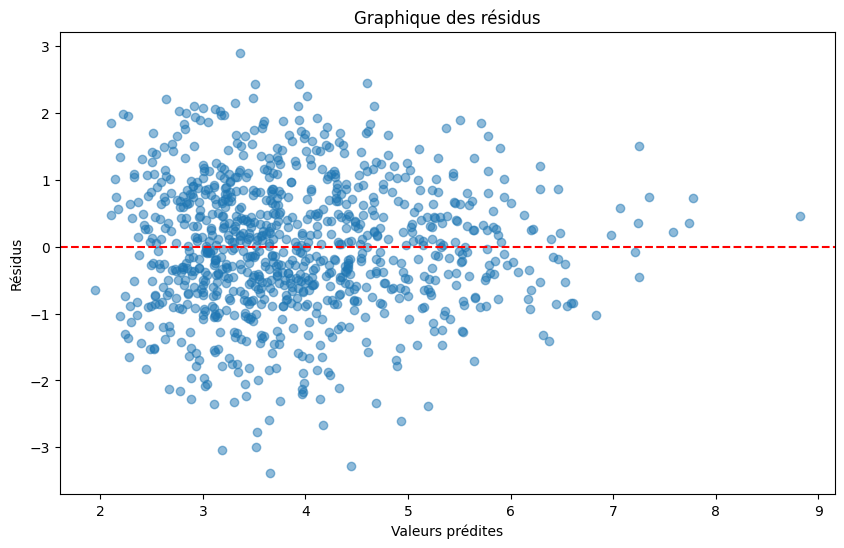

In [58]:
# Graphique des résidus
residuals = y_train - ridge_reg_predict_with_scaler

plt.figure(figsize=(10, 6))
plt.scatter(ridge_reg_predict_with_scaler, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [59]:
# Validation croisée
cv_scores = cross_val_score(ridge_reg_with_scaler, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [1.10319049 1.01761461 0.85375431 1.06185967 1.23535715 1.01850951
 0.92580893 0.95117296 1.00083539 1.10154375]
Moyenne des scores de la validation croisée (RMSE): 1.026964676047402


In [60]:
# Prédiction sur l'ensemble de test
y_test_pred_scaler = ridge_reg_with_scaler.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred_scaler, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred_scaler)
test_r2 = r2_score(y_test, y_test_pred_scaler)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 0.9965596778977502
Score MAE sur l'ensemble de test: 0.7857994923279681
Coefficient de détermination R² sur l'ensemble de test: 0.5253768976182269


In [61]:
# Recherche des meilleurs hyperparamètres
param_distributions_ridge = {
    'ridge_regressor__alpha': loguniform(0.001, 100),
    'ridge_regressor__fit_intercept': [True, False],
    'ridge_regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'ridge_regressor__max_iter': [10000, 20000]
}

n_iter_search = 10

random_search_ridge = RandomizedSearchCV(
    ridge_reg_with_scaler,
    param_distributions=param_distributions_ridge,
    n_iter=n_iter_search,
    cv=5,
    scoring='r2',
    refit=True,
    random_state=42
)

random_search_ridge.fit(X_train, y_train)

print(f'Meilleurs paramètres pour Ridge: {random_search_ridge.best_params_}')

Meilleurs paramètres pour Ridge: {'ridge_regressor__alpha': 7.915074397656218, 'ridge_regressor__fit_intercept': True, 'ridge_regressor__max_iter': 10000, 'ridge_regressor__solver': 'svd'}


In [62]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search_ridge.best_estimator_
y_test_pred_scaler = best_model.predict(X_test)

test_rmse_scaler_ridge = mean_squared_error(y_test, y_test_pred_scaler, squared=False)
test_mae_scaler_ridge = mean_absolute_error(y_test, y_test_pred_scaler)
test_r2_scaler_ridge = r2_score(y_test, y_test_pred_scaler)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_scaler_ridge}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_scaler_ridge}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_scaler_ridge}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 0.9955615976600756
Score MAE sur l'ensemble de test avec le meilleur modèle: 0.7852487204169772
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: 0.5263271161188661


#ELASTIC NET

In [63]:
elastic_net_reg = Pipeline(steps=[
    (('elastic_net', ElasticNet(max_iter=10000, random_state=42)))
])

In [64]:
# Entraînement du modèle
elastic_net_start_time = time.time()
elastic_net_reg.fit(X_train, y_train)
elastic_net_end_time = time.time()

elastic_net_reg_predict = elastic_net_reg.predict(X_train)

In [65]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", elastic_net_reg_predict[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [3.74 3.53 4.14 3.51 3.86]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [66]:
# Calcul des métriques d'évaluation
elastic_net_reg_rmse = mean_squared_error(y_train, elastic_net_reg_predict, squared=False)
elastic_net_reg_mae = mean_absolute_error(y_train, elastic_net_reg_predict)
elastic_net_reg_r2 = r2_score(y_train, elastic_net_reg_predict)

print('Score RMSE:', elastic_net_reg_rmse.round(2))
print('Score MAE:', elastic_net_reg_mae.round(2))
print('Coefficient de détermination R²:', elastic_net_reg_r2.round(2))

Score RMSE: 1.32
Score MAE: 1.06
Coefficient de détermination R²: 0.17


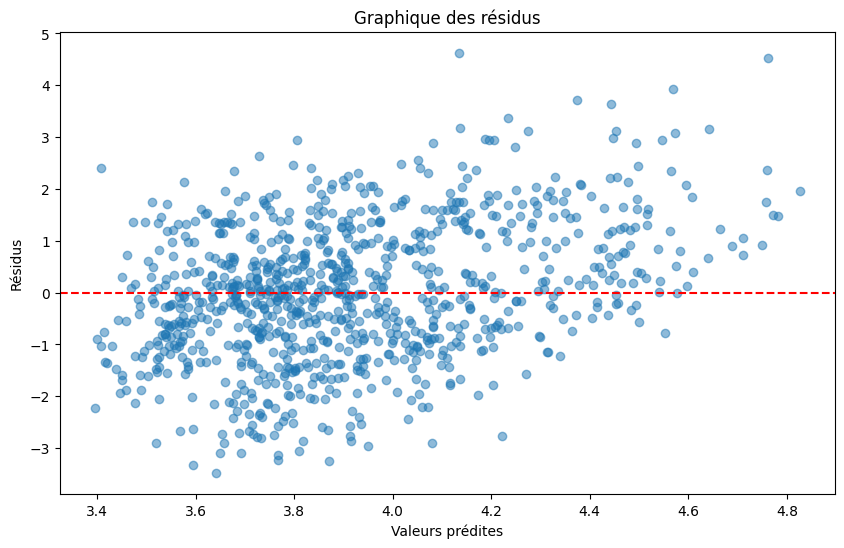

In [67]:
# Graphique des résidus
residuals = y_train - elastic_net_reg_predict

plt.figure(figsize=(10, 6))
plt.scatter(elastic_net_reg_predict, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [68]:
# Validation croisée
cv_scores = cross_val_score(elastic_net_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [1.38391991 1.33797045 1.12533071 1.36810545 1.40269313 1.5039866
 1.17189083 1.26203129 1.41500968 1.27143012]
Moyenne des scores de la validation croisée (RMSE): 1.324236815940359


In [69]:
# Prédiction sur l'ensemble de test
y_test_pred = elastic_net_reg.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 1.3168162841818354
Score MAE sur l'ensemble de test: 1.0138319221610919
Coefficient de détermination R² sur l'ensemble de test: 0.17130898763898295


In [70]:
# Recherche des meilleurs hyperparamètres
param_distributions_elastic_net = {
    'elastic_net__alpha': loguniform(0.1, 10000),
    'elastic_net__l1_ratio': loguniform(0.01, 1),
    'elastic_net__fit_intercept': [True, False]
}

n_iter_search = 10

random_search_elastic_net = RandomizedSearchCV(
    elastic_net_reg,
    param_distributions=param_distributions_elastic_net,
    n_iter=n_iter_search,
    cv=5,
    scoring='r2',
    refit=True,
    random_state=42
)

random_search_elastic_net.fit(X_train, y_train)

print(f'Meilleurs paramètres pour Elastic Net: {random_search_elastic_net.best_params_}')

Meilleurs paramètres pour Elastic Net: {'elastic_net__alpha': 0.1084754664013074, 'elastic_net__fit_intercept': True, 'elastic_net__l1_ratio': 0.038234752246751866}


In [71]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search_elastic_net.best_estimator_
y_test_pred = best_model.predict(X_test)

test_rmse_elastic_net = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae_elastic_net = mean_absolute_error(y_test, y_test_pred)
test_r2_elastic_net = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_elastic_net}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_elastic_net}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_elastic_net}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 1.0520415943760764
Score MAE sur l'ensemble de test avec le meilleur modèle: 0.8376725283548373
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: 0.4710579754298124


## Avec StandardScaler

In [72]:
elastic_net_reg_with_scaler = Pipeline(steps=[
    ('scaler', StandardScaler()),
    (('elastic_net', ElasticNet(max_iter=100, random_state=42)))
])

In [73]:
# Entraînement du modèle
elastic_net_scaler_start_time = time.time()
elastic_net_reg_with_scaler.fit(X_train, y_train)
elastic_net_scaler_end_time = time.time()

elastic_net_reg_predict_with_scaler = elastic_net_reg_with_scaler.predict(X_train)

In [74]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", elastic_net_reg_predict_with_scaler[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [3.67 3.6  4.22 3.68 3.78]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [75]:
# Calcul des métriques d'évaluation
elastic_net_reg_scaler_rmse = mean_squared_error(y_train, elastic_net_reg_predict_with_scaler, squared=False)
elastic_net_reg_scaler__mae = mean_absolute_error(y_train, elastic_net_reg_predict_with_scaler)
elastic_net_reg_scaler_r2 = r2_score(y_train, elastic_net_reg_predict_with_scaler)

print('Score RMSE:', elastic_net_reg_scaler_rmse.round(2))
print('Score MAE:', elastic_net_reg_scaler__mae.round(2))
print('Coefficient de détermination R²:', elastic_net_reg_scaler_r2.round(2))

Score RMSE: 1.3
Score MAE: 1.04
Coefficient de détermination R²: 0.19


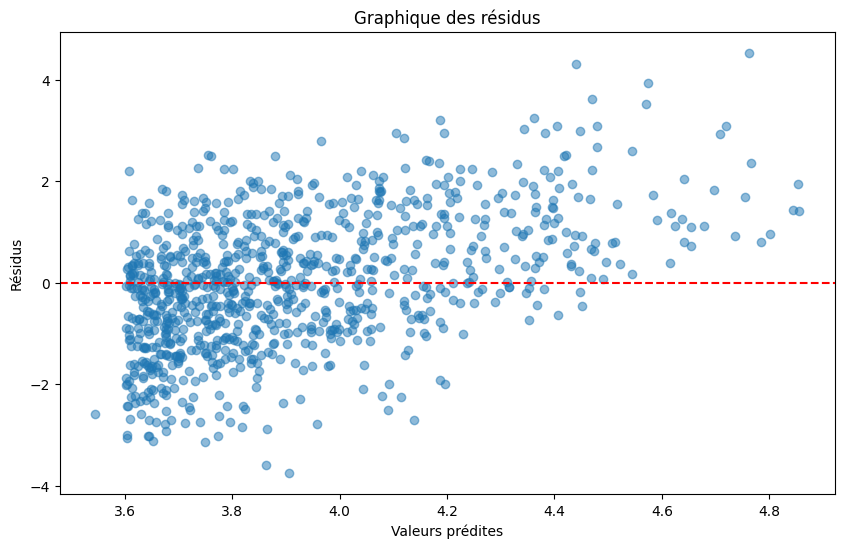

In [76]:
# Graphique des résidus
residuals = y_train - elastic_net_reg_predict_with_scaler

plt.figure(figsize=(10, 6))
plt.scatter(elastic_net_reg_predict_with_scaler, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [77]:
# Validation croisée
cv_scores = cross_val_score(elastic_net_reg_with_scaler, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [1.34909449 1.30526461 1.10515951 1.35555472 1.38147404 1.47016989
 1.1399833  1.24072875 1.39459674 1.28873867]
Moyenne des scores de la validation croisée (RMSE): 1.30307647155694


In [78]:
# Prédiction sur l'ensemble de test
y_test_pred_scaler = elastic_net_reg_with_scaler.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred_scaler, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred_scaler)
test_r2 = r2_score(y_test, y_test_pred_scaler)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 1.3041281106375893
Score MAE sur l'ensemble de test: 1.0014658418364262
Coefficient de détermination R² sur l'ensemble de test: 0.1872017419260169


In [79]:
# Recherche des meilleurs hyperparamètres
param_distributions_elastic_net = {
    'elastic_net__alpha': loguniform(0.1, 100),
    'elastic_net__l1_ratio': loguniform(0.1, 1),
    'elastic_net__fit_intercept': [True, False]
}

n_iter_search = 10

random_search_elastic_net = RandomizedSearchCV(
    elastic_net_reg_with_scaler,
    param_distributions=param_distributions_elastic_net,
    n_iter=n_iter_search,
    cv=5,
    scoring='r2',
    refit=True,
    random_state=42
)

random_search_elastic_net.fit(X_train, y_train)

print(f'Meilleurs paramètres pour Elastic Net: {random_search_elastic_net.best_params_}')

Meilleurs paramètres pour Elastic Net: {'elastic_net__alpha': 0.10500232504231348, 'elastic_net__fit_intercept': True, 'elastic_net__l1_ratio': 0.1955370866274525}


In [80]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search_elastic_net.best_estimator_
y_test_pred_scaler = best_model.predict(X_test)

test_rmse_scaler_elastic_net = mean_squared_error(y_test, y_test_pred_scaler, squared=False)
test_mae_scaler_elastic_net = mean_absolute_error(y_test, y_test_pred_scaler)
test_r2_scaler_elastic_net = r2_score(y_test, y_test_pred_scaler)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_scaler_elastic_net}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_scaler_elastic_net}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_scaler_elastic_net}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 1.005856356059886
Score MAE sur l'ensemble de test avec le meilleur modèle: 0.797517850650151
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: 0.5164802915210414


# BAGGING : RANDOM FOREST REGRESSOR

In [81]:
bagging_rf = Pipeline(steps=[
    ('bagging_random_forest', BaggingRegressor(
        estimator=RandomForestRegressor(n_estimators=100, random_state=42),
        random_state=42
    ))
])

In [82]:
# Entraînement du modèle
bagging_rf_start_time = time.time()
bagging_rf.fit(X_train, y_train)
bagging_rf_end_time = time.time()

bagging_rf_predict = bagging_rf.predict(X_train)

In [83]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", bagging_rf_predict[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [4.27 2.31 5.19 2.83 2.89]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [84]:
# Calcul des métriques d'évaluation
bagging_rf_rmse = mean_squared_error(y_train, bagging_rf_predict, squared=False)
bagging_rf_mae = mean_absolute_error(y_train, bagging_rf_predict)
bagging_rf_r2 = r2_score(y_train, bagging_rf_predict)

print('Score RMSE:', bagging_rf_rmse.round(2))
print('Score MAE:', bagging_rf_mae.round(2))
print('Coefficient de détermination R²:', bagging_rf_r2.round(2))

Score RMSE: 0.62
Score MAE: 0.48
Coefficient de détermination R²: 0.82


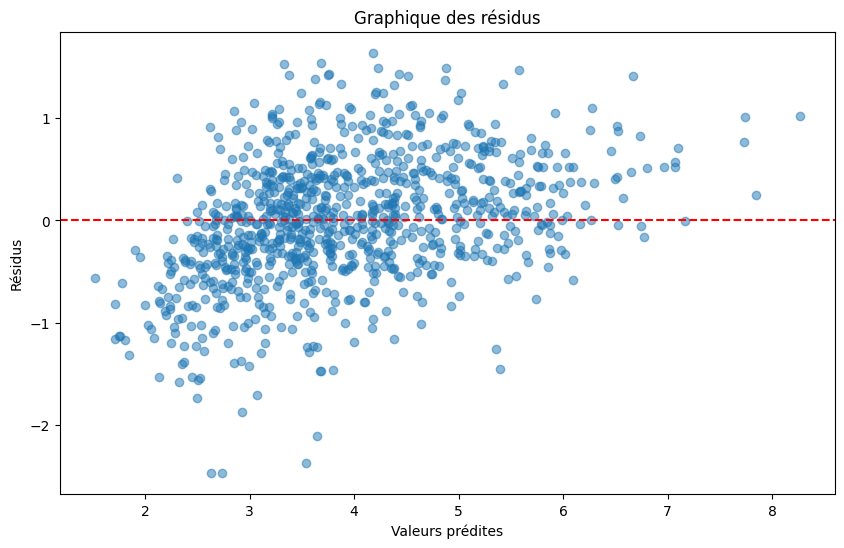

In [85]:
# Graphique des résidus
residuals = y_train - bagging_rf_predict

plt.figure(figsize=(10, 6))
plt.scatter(bagging_rf_predict, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [86]:
# Validation croisée
cv_scores = cross_val_score(bagging_rf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [1.04202274 0.92503897 0.87109595 1.01304643 1.1868713  1.0335495
 1.00966495 0.98541957 1.05933619 1.04553983]
Moyenne des scores de la validation croisée (RMSE): 1.0171585427591747


In [87]:
# Prédiction sur l'ensemble de test
y_test_pred = bagging_rf.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 1.000981500154563
Score MAE sur l'ensemble de test: 0.80043788053896
Coefficient de détermination R² sur l'ensemble de test: 0.5211556651127226


In [88]:
# Recherche des meilleurs hyperparamètres
param_distributions_bagging_rf = {
    'bagging_random_forest__n_estimators': randint(10, 101),
    'bagging_random_forest__estimator__n_estimators': randint(10, 101),
    'bagging_random_forest__max_samples': uniform(0.5, 0.5),
    'bagging_random_forest__max_features': uniform(0.5, 0.5)

}

n_iter_search = 10

random_search_bagging_rf = RandomizedSearchCV(
    bagging_rf,
    param_distributions=param_distributions_bagging_rf,
    n_iter=n_iter_search,
    cv=5,
    scoring='r2',
    refit=True,
    random_state=42
)

random_search_bagging_rf.fit(X_train, y_train)

print(f'Meilleurs paramètres pour Bagging RandomForestRegressor: {random_search_bagging_rf.best_params_}')

Meilleurs paramètres pour Bagging RandomForestRegressor: {'bagging_random_forest__estimator__n_estimators': 61, 'bagging_random_forest__max_features': 0.9753571532049581, 'bagging_random_forest__max_samples': 0.8659969709057025, 'bagging_random_forest__n_estimators': 70}


In [89]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search_bagging_rf.best_estimator_
y_test_pred = best_model.predict(X_test)

test_rmse_bagging = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae_bagging = mean_absolute_error(y_test, y_test_pred)
test_r2_bagging = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_bagging}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_bagging}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_bagging}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 0.9977360697759805
Score MAE sur l'ensemble de test avec le meilleur modèle: 0.7981853937992013
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: 0.5242556956993607


# BOOSTING : ADABOOST REGRESSOR

In [90]:
ada_boost = Pipeline(steps=[
    ('ada_boost', AdaBoostRegressor(
        estimator=DecisionTreeRegressor(random_state=42),
        random_state=42
    ))
])

In [91]:
# Entraînement du modèle
ada_boost_start_time = time.time()
ada_boost.fit(X_train, y_train)
ada_boost_end_time = time.time()

ada_boost_predict = ada_boost.predict(X_train)

In [92]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", ada_boost_predict[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [93]:
# Calcul des métriques d'évaluation
ada_boost_rmse = mean_squared_error(y_train, ada_boost_predict, squared=False)
ada_boost_mae = mean_absolute_error(y_train, ada_boost_predict)
ada_boost_r2 = r2_score(y_train, ada_boost_predict)

print('Score RMSE:', ada_boost_rmse.round(2))
print('Score MAE:', ada_boost_mae.round(2))
print('Coefficient de détermination R²:', ada_boost_r2.round(2))

Score RMSE: 0.04
Score MAE: 0.01
Coefficient de détermination R²: 1.0


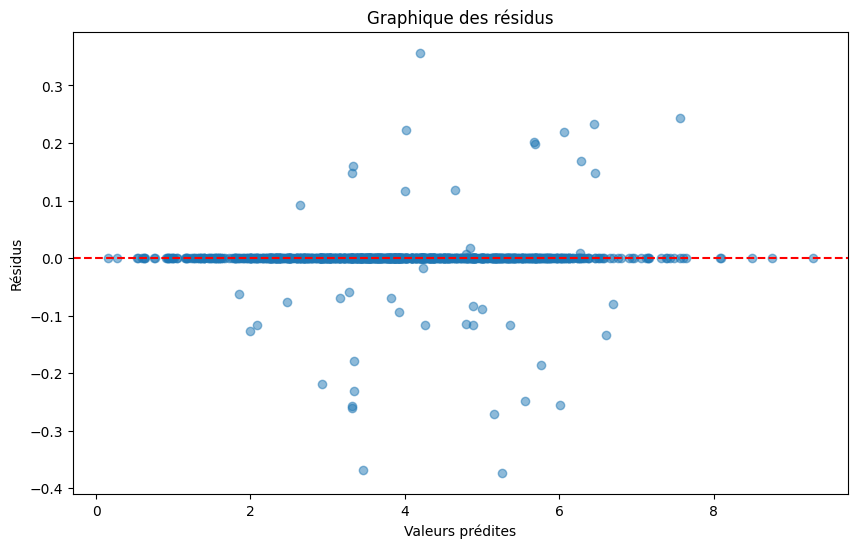

In [94]:
# Graphique des résidus
residuals = y_train - ada_boost_predict

plt.figure(figsize=(10, 6))
plt.scatter(ada_boost_predict, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [95]:
# Validation croisée
cv_scores = cross_val_score(ada_boost, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [0.99951541 0.99197917 0.8997202  1.04157602 1.21791785 1.02461318
 1.14089616 1.03211058 1.06989432 1.03771376]
Moyenne des scores de la validation croisée (RMSE): 1.0455936649990671


In [96]:
# Prédiction sur l'ensemble de test
y_test_pred = ada_boost.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 1.0275184308908387
Score MAE sur l'ensemble de test: 0.8191674257106264
Coefficient de détermination R² sur l'ensemble de test: 0.49542992133786723


In [97]:
# Recherche des meilleurs hyperparamètres
param_distributions_ada_boost = {
    'ada_boost__n_estimators': randint(50, 500),
    'ada_boost__learning_rate': uniform(0.01, 1),
    'ada_boost__estimator__max_depth': randint(1, 11),
}

n_iter_search = 10

random_search_ada_boost = RandomizedSearchCV(
    ada_boost,
    param_distributions=param_distributions_ada_boost,
    n_iter=n_iter_search,
    cv=5,
    scoring='r2',
    refit=True,
    random_state=42
)

random_search_ada_boost.fit(X_train, y_train)

print(f'Meilleurs paramètres pour AdaBoostRegressor: {random_search_ada_boost.best_params_}')

Meilleurs paramètres pour AdaBoostRegressor: {'ada_boost__estimator__max_depth': 8, 'ada_boost__learning_rate': 0.6086584841970366, 'ada_boost__n_estimators': 152}


In [98]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search_ada_boost.best_estimator_
y_test_pred = best_model.predict(X_test)

test_rmse_boosting = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae_boosting = mean_absolute_error(y_test, y_test_pred)
test_r2_boosting = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_boosting}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_boosting}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_boosting}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 1.0087758283891242
Score MAE sur l'ensemble de test avec le meilleur modèle: 0.8156784888760947
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: 0.5136694110210855


# BOOSTING : XGBOOST REGRESSOR

In [99]:
xgboost_reg = Pipeline([
    ('xgb', XGBRegressor(random_state=42))
])

In [100]:
# Entraînement du modèle
xgboost_start_time = time.time()
xgboost_reg.fit(X_train, y_train)
xgboost_end_time = time.time()

xgboost_predict = xgboost_reg.predict(X_train)

In [101]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", xgboost_predict[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [5.53 2.77 5.78 2.5  2.23]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [102]:
# Calcul des métriques d'évaluation
xgboost_rmse = mean_squared_error(y_train, ada_boost_predict, squared=False)
xgboost_mae = mean_absolute_error(y_train, ada_boost_predict)
xgboost_r2 = r2_score(y_train, ada_boost_predict)

print('Score RMSE:', xgboost_rmse.round(2))
print('Score MAE:', xgboost_mae.round(2))
print('Coefficient de détermination R²:', xgboost_r2.round(2))

Score RMSE: 0.04
Score MAE: 0.01
Coefficient de détermination R²: 1.0


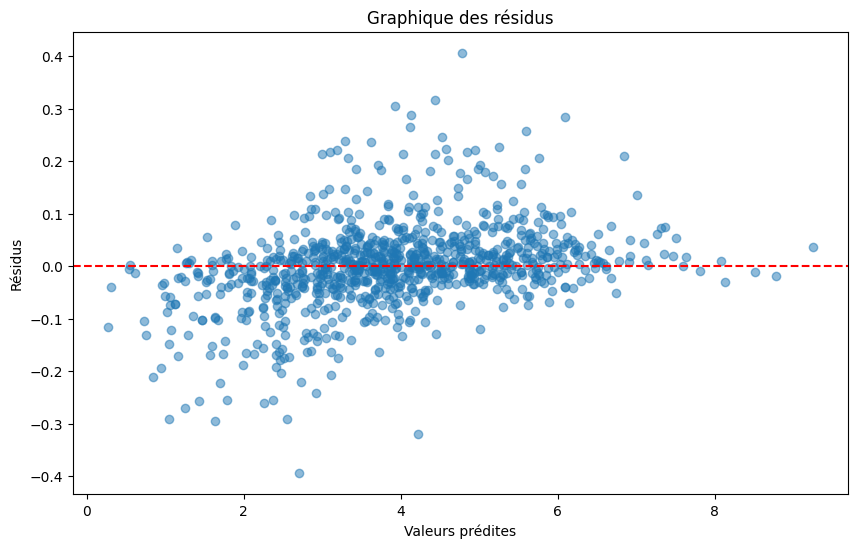

In [103]:
# Graphique des résidus
residuals = y_train - xgboost_predict

plt.figure(figsize=(10, 6))
plt.scatter(xgboost_predict, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [104]:
# Validation croisée
cv_scores = cross_val_score(xgboost_reg, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [1.12246782 1.01673178 0.95236379 1.09314438 1.27685586 1.15771296
 1.12066871 1.10899342 1.10892417 1.04840965]
Moyenne des scores de la validation croisée (RMSE): 1.1006272527955923


In [105]:
# Prédiction sur l'ensemble de test
y_test_pred = xgboost_reg.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 1.0757756422473455
Score MAE sur l'ensemble de test: 0.851805344537363
Coefficient de détermination R² sur l'ensemble de test: 0.4469229151279105


In [106]:
# Recherche des meilleurs hyperparamètres
param_distributions_xgb = {
    'xgb__n_estimators': randint(50, 500),
    'xgb__learning_rate': uniform(0.01, 0.99),
    'xgb__max_depth': randint(3, 10),
    'xgb__min_child_weight': randint(1, 10),
    'xgb__subsample': uniform(0.5, 0.5),
    'xgb__colsample_bytree': uniform(0.5, 0.5)
}

n_iter_search = 10

random_search_xgb = RandomizedSearchCV(
    xgboost_reg,
    param_distributions=param_distributions_xgb,
    n_iter=n_iter_search,
    cv=5,
    scoring='r2',
    refit=True,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)

print(f'Meilleurs paramètres pour XGBRegressor: {random_search_xgb.best_params_}')

Meilleurs paramètres pour XGBRegressor: {'xgb__colsample_bytree': 0.7962072844310213, 'xgb__learning_rate': 0.05598590859279775, 'xgb__max_depth': 5, 'xgb__min_child_weight': 7, 'xgb__n_estimators': 70, 'xgb__subsample': 0.7252496259847715}


In [107]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search_xgb.best_estimator_
y_test_pred = best_model.predict(X_test)

test_rmse_boosting_xgb = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae_boosting_xgb = mean_absolute_error(y_test, y_test_pred)
test_r2_boosting_xgb = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_boosting_xgb}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_boosting_xgb}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_boosting_xgb}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 0.9982250442174482
Score MAE sur l'ensemble de test avec le meilleur modèle: 0.7955440818150221
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: 0.5237892721313286


# SVR

In [108]:
svr = Pipeline([
 ('svr', SVR(kernel='rbf'))
])

In [109]:
# Entraînement du modèle
svr_start_time = time.time()
svr.fit(X_train, y_train)
svr_end_time = time.time()

svr_predict = svr.predict(X_train)

In [110]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", svr_predict[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [3.83 3.62 3.91 3.56 3.88]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [111]:
# Calcul des métriques d'évaluation
svr_rmse = mean_squared_error(y_train, ada_boost_predict, squared=False)
svr_mae = mean_absolute_error(y_train, ada_boost_predict)
svr_r2 = r2_score(y_train, ada_boost_predict)

print('Score RMSE:', svr_rmse.round(2))
print('Score MAE:', svr_mae.round(2))
print('Coefficient de détermination R²:', svr_r2.round(2))

Score RMSE: 0.04
Score MAE: 0.01
Coefficient de détermination R²: 1.0


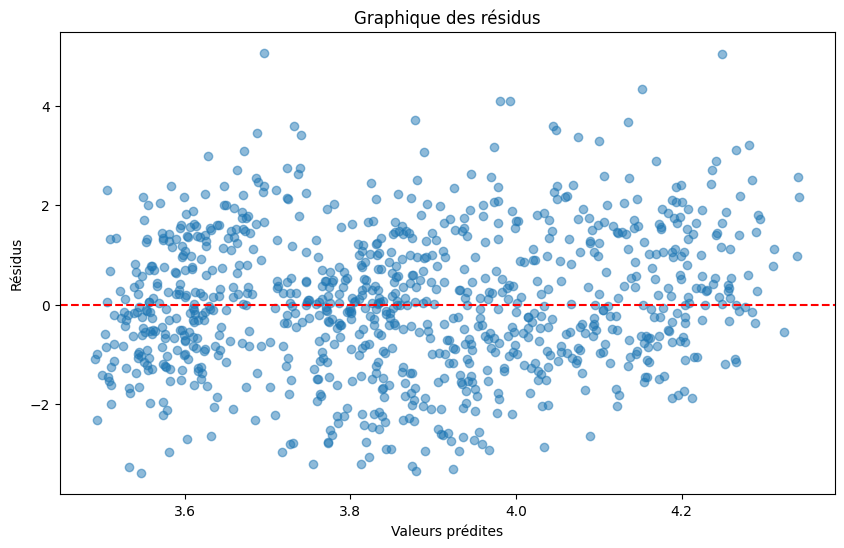

In [112]:
# Graphique des résidus
residuals = y_train - svr_predict

plt.figure(figsize=(10, 6))
plt.scatter(svr_predict, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [113]:
# Validation croisée
cv_scores = cross_val_score(svr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [1.47534665 1.42721733 1.23474692 1.46812114 1.48145494 1.59483257
 1.26104319 1.3398083  1.52492799 1.33666111]
Moyenne des scores de la validation croisée (RMSE): 1.4144160137556863


In [114]:
# Prédiction sur l'ensemble de test
y_test_pred = svr.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 1.3947085447486558
Score MAE sur l'ensemble de test: 1.0764329818638894
Coefficient de détermination R² sur l'ensemble de test: 0.07037204516965101


In [115]:
# Recherche des meilleurs hyperparamètres
param_distributions_svr = {
    'svr__C': reciprocal(1e-4, 1e4),
    'svr__epsilon': expon(scale=0.1),
    'svr__gamma': expon(scale=0.1)
}

n_iter_search = 10

random_search_svr = RandomizedSearchCV(
    svr,
    param_distributions=param_distributions_svr,
    n_iter=n_iter_search,
    cv=5,
    scoring='r2',
    refit=True,
    random_state=42
)

random_search_svr.fit(X_train, y_train)

print(f'Meilleurs paramètres pour SVR: {random_search_svr.best_params_}')

Meilleurs paramètres pour SVR: {'svr__C': 6.155564318973028, 'svr__epsilon': 0.01696248704623463, 'svr__gamma': 0.016959629191460518}


In [116]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search_svr.best_estimator_
y_test_pred = best_model.predict(X_test)

test_rmse_svr = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae_svr = mean_absolute_error(y_test, y_test_pred)
test_r2_svr = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_svr}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_svr}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_svr}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 1.0701504116491536
Score MAE sur l'ensemble de test avec le meilleur modèle: 0.8384056078936403
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: 0.45269187256344645


## Avec StardardScaler

In [117]:
svr_scaler = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

In [118]:
# Entraînement du modèle
svr_scaler_start_time = time.time()
svr_scaler.fit(X_train, y_train)
svr_scaler_end_time = time.time()

svr_scaler_predict = svr_scaler.predict(X_train)

In [119]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", svr_scaler_predict[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [4.85 2.21 4.7  3.04 3.77]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [120]:
# Calcul des métriques d'évaluation
svr_scaler_rmse = mean_squared_error(y_train, svr_scaler_predict, squared=False)
svr_scaler_mae = mean_absolute_error(y_train, svr_scaler_predict)
svr_scaler_r2 = r2_score(y_train, svr_scaler_predict)

print('Score RMSE:', svr_scaler_rmse.round(2))
print('Score MAE:', svr_scaler_mae.round(2))
print('Coefficient de détermination R²:', svr_scaler_r2.round(2))

Score RMSE: 0.9
Score MAE: 0.65
Coefficient de détermination R²: 0.61


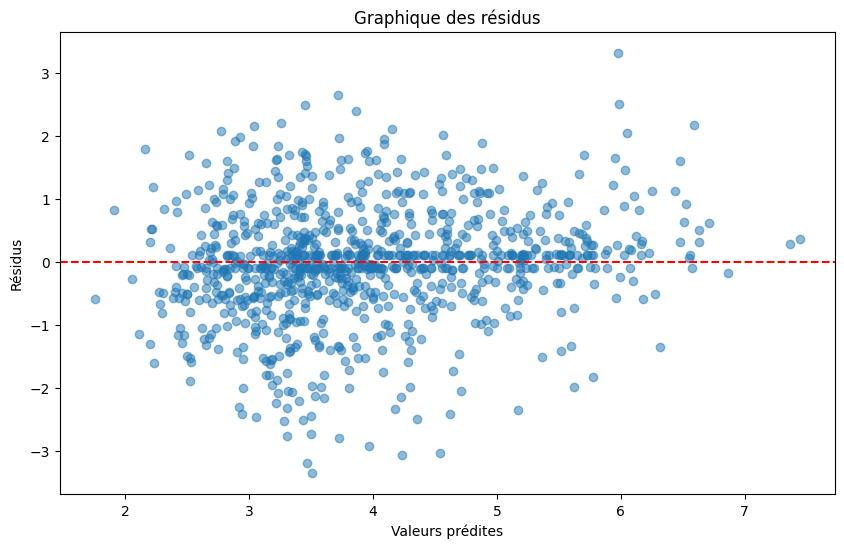

In [121]:
# Graphique des résidus
residuals = y_train - svr_scaler_predict

plt.figure(figsize=(10, 6))
plt.scatter(svr_scaler_predict, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [122]:
# Validation croisée
cv_scores = cross_val_score(svr_scaler, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [1.21707979 1.05503903 0.87002802 1.0836524  1.24296791 1.08994055
 0.94475835 1.03707283 1.10738174 1.10661779]
Moyenne des scores de la validation croisée (RMSE): 1.0754538419252069


In [123]:
# Prédiction sur l'ensemble de test
y_test_pred = svr_scaler.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 1.053857287884479
Score MAE sur l'ensemble de test: 0.8269734914912348
Coefficient de détermination R² sur l'ensemble de test: 0.4692306230356279


In [124]:
# Recherche des meilleurs hyperparamètres
param_distributions_svr = {
    'svr__C': reciprocal(1e-4, 1e4),
    'svr__epsilon': expon(scale=0.1),
    'svr__gamma': expon(scale=0.1)
}

n_iter_search = 10

random_search_svr_scaler = RandomizedSearchCV(
    svr_scaler,
    param_distributions=param_distributions_svr,
    n_iter=n_iter_search,
    cv=5,
    scoring='neg_mean_absolute_error',
    refit=True,
    random_state=42
)

random_search_svr_scaler.fit(X_train, y_train)

print(f'Meilleurs paramètres pour SVR: {random_search_svr_scaler.best_params_}')

Meilleurs paramètres pour SVR: {'svr__C': 1.2997969313168272, 'svr__epsilon': 0.08975047213097606, 'svr__gamma': 0.004756384975640855}


In [125]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search_svr_scaler.best_estimator_
y_test_pred = best_model.predict(X_test)

test_rmse_svr_scaler = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae_svr_scaler = mean_absolute_error(y_test, y_test_pred)
test_r2_svr_scaler = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_svr_scaler}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_svr_scaler}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_svr_scaler}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 1.0208640453844635
Score MAE sur l'ensemble de test avec le meilleur modèle: 0.7872221442865417
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: 0.5019441239230933


# STACKING :  STACKING REGRESSOR

In [126]:
# Définition des modèles de base pour le stacking
ridge = make_pipeline(StandardScaler(), Ridge())
linear_regression = LinearRegression()
elasticnet = make_pipeline(StandardScaler(), ElasticNet(max_iter=10000, random_state=42))

estimators = [
    ('ridge', ridge),
    ('linear_regression', linear_regression),
    ('elastic_net_scaler', elasticnet),
]

meta_model = LinearRegression()

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model
)

In [127]:
# Entraînement du modèle
stacking_regressor_start_time = time.time()
stacking_regressor.fit(X_train, y_train)
stacking_regressor_end_time = time.time()

stacking_regressor_predict = stacking_regressor.predict(X_train)

In [128]:
# Affichage des prédictions et des valeurs réelles
print("Prédictions des 5 premières instances:", stacking_regressor_predict[:5].round(2))
print("Valeurs réelles des 5 premières instances:", y_train.iloc[:5].values.round(2))

Prédictions des 5 premières instances: [3.77 2.54 4.41 3.2  3.11]
Valeurs réelles des 5 premières instances: [5.52 2.72 5.9  2.49 2.19]


In [129]:
# Calcul des métriques d'évaluation
stacking_regressor_rmse = mean_squared_error(y_train, stacking_regressor_predict, squared=False)
stacking_regressor_mae = mean_absolute_error(y_train, stacking_regressor_predict)
stacking_regressor_r2 = r2_score(y_train, stacking_regressor_predict)

print('Score RMSE:', stacking_regressor_rmse.round(2))
print('Score MAE:', stacking_regressor_mae.round(2))
print('Coefficient de détermination R²:', stacking_regressor_r2.round(2))

Score RMSE: 0.99
Score MAE: 0.8
Coefficient de détermination R²: 0.53


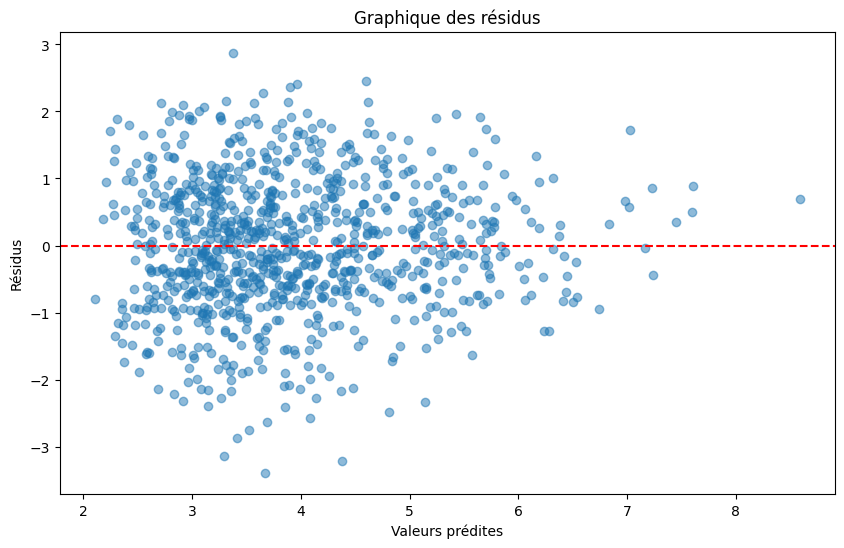

In [130]:
# Graphique des résidus
residuals = y_train - stacking_regressor_predict

plt.figure(figsize=(10, 6))
plt.scatter(stacking_regressor_predict, residuals, alpha=0.5)
plt.title('Graphique des résidus')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [131]:
# Validation croisée
cv_scores = cross_val_score(stacking_regressor, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)

print("Scores de la validation croisée (RMSE):", cv_rmse_scores)
print("Moyenne des scores de la validation croisée (RMSE):", cv_rmse_scores.mean())

Scores de la validation croisée (RMSE): [1.09410871 1.01085653 0.84919563 1.05766926 1.22311336 1.02761423
 0.93853487 0.96441548 1.00910081 1.10172116]
Moyenne des scores de la validation croisée (RMSE): 1.0276330029674852


In [132]:
# Prédiction sur l'ensemble de test
y_test_pred = stacking_regressor.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test: {test_rmse}')
print(f'Score MAE sur l\'ensemble de test: {test_mae}')
print(f'Coefficient de détermination R² sur l\'ensemble de test: {test_r2}')

Score RMSE sur l'ensemble de test: 0.9966358220236534
Score MAE sur l'ensemble de test: 0.7884991219380112
Coefficient de détermination R² sur l'ensemble de test: 0.5253043658015557


In [133]:
# Recherche des meilleurs hyperparamètres
param_distributions = {
    'ridge__ridge__alpha': uniform(0.1, 10),
    'elastic_net_scaler__elasticnet__alpha': uniform(0.1, 10),
    'elastic_net_scaler__elasticnet__l1_ratio': uniform(0, 1),
}

n_iter_search = 10

random_search_stacking = RandomizedSearchCV(
    estimator=stacking_regressor,
    param_distributions=param_distributions,
    n_iter=100,
    cv=5,
    scoring='r2',
    random_state=42
)

random_search_stacking.fit(X_train, y_train)

print(f'Meilleurs paramètres pour Stacking: {random_search_stacking.best_params_}')

Meilleurs paramètres pour Stacking: {'elastic_net_scaler__elasticnet__alpha': 0.155221171236024, 'elastic_net_scaler__elasticnet__l1_ratio': 0.8154614284548342, 'ridge__ridge__alpha': 7.168573438476171}


In [134]:
# Évaluation des Performances du Meilleur Modèle sur l'Ensemble de Test
best_model = random_search_stacking.best_estimator_
y_test_pred = best_model.predict(X_test)

test_rmse_stacking = mean_squared_error(y_test, y_test_pred, squared=False)
test_mae_stacking = mean_absolute_error(y_test, y_test_pred)
test_r2_stacking = r2_score(y_test, y_test_pred)

print(f'Score RMSE sur l\'ensemble de test avec le meilleur modèle: {test_rmse_stacking}')
print(f'Score MAE sur l\'ensemble de test avec le meilleur modèle: {test_mae_stacking}')
print(f'Coefficient de détermination R² sur l\'ensemble de test avec le meilleur modèle: {test_r2_stacking}')

Score RMSE sur l'ensemble de test avec le meilleur modèle: 1.00163032821849
Score MAE sur l'ensemble de test avec le meilleur modèle: 0.7984040390334598
Coefficient de détermination R² sur l'ensemble de test avec le meilleur modèle: 0.5205346979214601


# ANALYSE DES RESULTATS

In [135]:
# Calcul des temps d'exécution pour différents modèles de régression
lr_execution_time = lr_end_time - lr_start_time
lr_scaler_execution_time = lr_scaler_end_time - lr_scaler_start_time
lasso_execution_time = lasso_end_time - lasso_start_time
lasso_scaler_execution_time = lasso_scaler_end_time - lasso_scaler_start_time
ridge_execution_time = ridge_end_time - ridge_start_time
ridge_scaler_execution_time = ridge_scaler_end_time - ridge_scaler_start_time
elastic_net_execution_time = elastic_net_end_time - elastic_net_start_time
elastic_net_scaler_execution_time = elastic_net_scaler_end_time - elastic_net_scaler_start_time
bagging_rf_execution_time = bagging_rf_end_time - bagging_rf_start_time
ada_boost_execution_time = ada_boost_end_time - ada_boost_start_time
xgboost_executive_time = xgboost_end_time - xgboost_start_time
svr_executive_time = svr_end_time - svr_start_time
svr_scaler_executive_time = svr_scaler_end_time - svr_scaler_start_time
stacking_regressor_execution_time = stacking_regressor_end_time - stacking_regressor_start_time

In [136]:
# Creation & Affichage du tableau de résultats
results = {
    'Model': [
        'Linear Regression',
        'Linear Regression avec StandardScaler',
        'Lasso',
        'Lasso avec StandardScaler',
        'Ridge',
        'Ridge avec StandardScaler',
        'Elastic Net',
        'Elastic Net avec StandardScaler',
        'Bagging RandomForest',
        'Boosting AdaBoost',
        'Boosting XGBoost',
        'SVR',
        'SVR avec StandardScaler',
        'Stacking Regressor'
    ],
    'MAE': [
        test_mae_lr,
        test_mae_lr_scaler,
        test_mae_lasso,
        test_mae_scaler_lasso,
        test_mae_ridge,
        test_mae_scaler_ridge,
        test_mae_elastic_net,
        test_mae_scaler_elastic_net,
        test_mae_bagging,
        test_mae_boosting,
        test_mae_boosting_xgb,
        test_mae_svr,
        test_mae_svr_scaler,
        test_mae_stacking
    ],
    'RMSE': [
        test_rmse_lr,
        test_rmse_lr_scaler,
        test_rmse_lasso,
        test_rmse_scaler_lasso,
        test_rmse_ridge,
        test_rmse_scaler_ridge,
        test_rmse_elastic_net,
        test_rmse_scaler_elastic_net,
        test_rmse_bagging,
        test_rmse_boosting,
        test_rmse_boosting_xgb,
        test_rmse_svr,
        test_rmse_svr_scaler,
        test_rmse_stacking
    ],
    'R2': [
        test_r2_lr,
        test_r2_lr_scaler,
        test_r2_lasso,
        test_r2_scaler_lasso,
        test_r2_ridge,
        test_r2_scaler_ridge,
        test_r2_elastic_net,
        test_r2_scaler_elastic_net,
        test_r2_bagging,
        test_r2_boosting,
        test_r2_boosting_xgb,
        test_r2_svr,
        test_r2_svr_scaler,
        test_r2_stacking
    ],
    'Execution Time (s)': [
        lr_execution_time,
        lr_scaler_execution_time,
        lasso_execution_time,
        lasso_scaler_execution_time,
        ridge_execution_time,
        ridge_scaler_execution_time,
        elastic_net_execution_time,
        elastic_net_scaler_execution_time,
        bagging_rf_execution_time,
        ada_boost_execution_time,
        xgboost_executive_time,
        svr_executive_time,
        svr_scaler_executive_time,
        stacking_regressor_execution_time
    ]
}


results_df = pd.DataFrame(results)

results_df

,Model,MAE,RMSE,R2,Execution Time (s)
0,Linear Regression,0.785890,0.996729,0.525216,0.051327
1,Linear Regression avec StandardScaler,0.789977,0.999048,0.523004,0.037104
2,Lasso,0.892204,1.111732,0.409334,0.022951
3,Lasso avec StandardScaler,1.113083,1.446718,-0.000253,0.018053
4,Ridge,0.794958,1.005764,0.516569,0.044054
5,Ridge avec StandardScaler,0.785249,0.995562,0.526327,0.017502
6,Elastic Net,0.837673,1.052042,0.471058,0.015070
7,Elastic Net avec StandardScaler,0.797518,1.005856,0.516480,0.033088
8,Bagging RandomForest,0.798185,0.997736,0.524256,5.547982
9,Boosting AdaBoost,0.815678,1.008776,0.513669,0.452228


**En conclusion :**

**Régression Linéaire:** Les performances sont relativement constantes avec et sans standardisation, bien que la standardisation n'ait pas amélioré les résultats pour ce modèle.  

**Lasso:** Ce modèle a montré une performance inférieure par rapport à la régression linéaire, et la standardisation a considérablement réduit sa précision, ce qui suggère une sensibilité aux échelles des caractéristiques.  

**Ridge:** Des résultats similaires à la régression linéaire, avec une légère amélioration en termes de R2 lors de l'utilisation de la standardisation.  

**Elastic Net:** Les performances sont meilleures sans standardisation, mais restent inférieures à celles de la régression linéaire et du Ridge.  

**Bagging avec RandomForest:** Des performances comparables à celles des modèles linéaires, mais avec un temps d'exécution beaucoup plus long, ce qui peut être un inconvénient pour des applications en temps réel.  

**Boosting avec AdaBoost et XGBoost:** Des performances légèrement inférieures à celles des modèles linéaires, avec un temps d'exécution notablement plus long pour AdaBoost.  

**SVR:** Des performances modérées qui s'améliorent légèrement avec la standardisation, mais qui restent en deçà des modèles linéaires et de Ridge.
Stacking Regressor: Des performances compétitives, mais avec un temps d'exécution plus élevé que les modèles linéaires simples.  

**Le modèle Ridge avec StandardScaler se distingue** comme le plus performant en termes de MAE, RMSE et R2, tout en maintenant un temps d'exécution raisonnable. Cela indique que la standardisation des caractéristiques peut être bénéfique pour les modèles sensibles à l'échelle des variables.

## Feature Importances

In [137]:
# Extraction des noms des caractéristiques
feature_names = X_train.columns.tolist()

In [138]:
# Affichage des importances des caractéristiques pour le modèle Ridge
ridge_estimator = ridge_reg_with_scaler.named_steps['ridge_regressor']
coefficients = ridge_estimator.coef_

importances = np.abs(coefficients)

indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {feature_names[indices[f]]} ({importances[indices[f]]})")

Feature importances:
1. feature log_PropertyGFATotal (0.8615435293983932)
2. feature PrimaryPropertyType_Storage (0.2886302096354091)
3. feature Latitude (0.22235400941447334)
4. feature PrimaryPropertyType_Hospitality (0.18815250270965456)
5. feature ResidentialSection (0.1601174155558898)
6. feature log_Parking_ratio (0.15959981827809916)
7. feature log_NumberOfActivities (0.1557563763580443)
8. feature PrimaryPropertyType_Retail (0.132695646641975)
9. feature PrimaryPropertyType_Other (0.12452889809021139)
10. feature log_LargestPropertyUseTypeGFA_ratio (0.12029795445916795)
11. feature Neighborhood_BALLARD (0.11961000749570408)
12. feature PrimaryPropertyType_Healthcare (0.11275969443945878)
13. feature Neighborhood_NORTHWEST (0.10469226760140123)
14. feature PrimaryPropertyType_Food Service (0.10183514404551958)
15. feature Neighborhood_GREATER DUWAMISH (0.10180108496878273)
16. feature Neighborhood_DOWNTOWN (0.09883236157767243)
17. feature log_AverageFloorArea (0.091091818075986

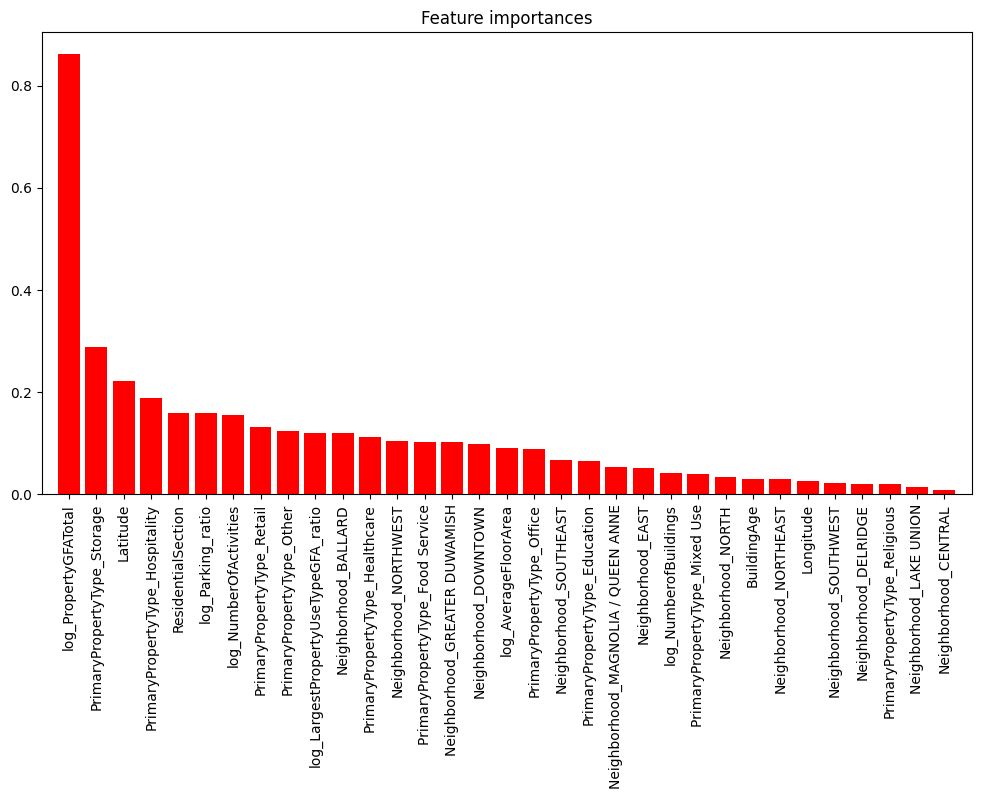

In [139]:
# Création du graphique
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

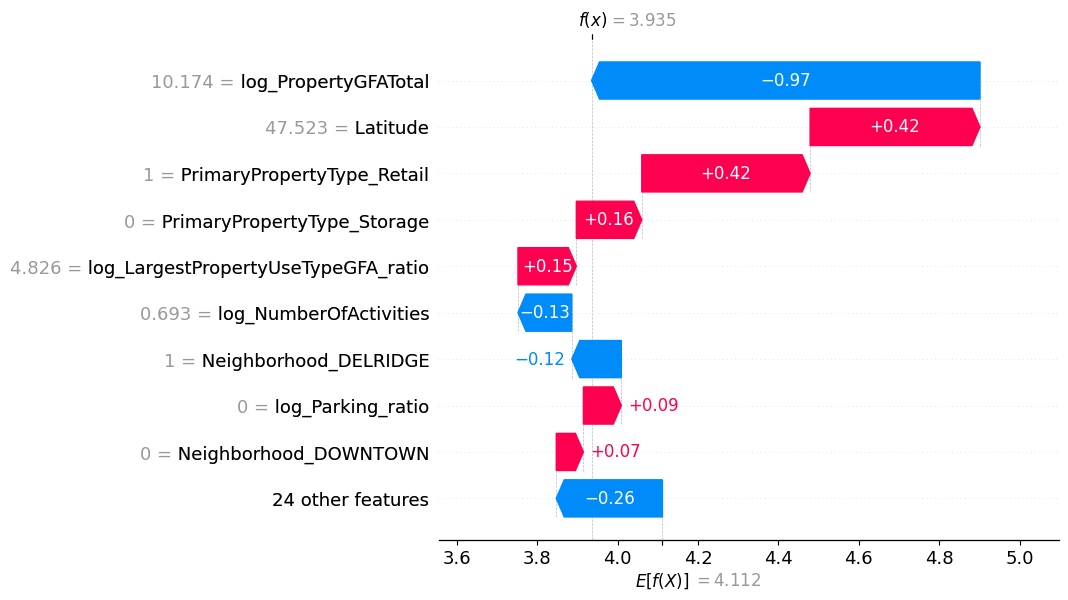

In [140]:
# Création d'un graphique en cascade SHAP pour l'instance de test sélectionnée avec le modèle Ridge
explainer = shap.Explainer(ridge_reg_with_scaler.predict, X_train)

i = 10
shap_values = explainer(X_test.iloc[i:i+1])

shap.plots.waterfall(shap_values[0])

PermutationExplainer explainer: 400it [00:16, 10.11it/s]                         


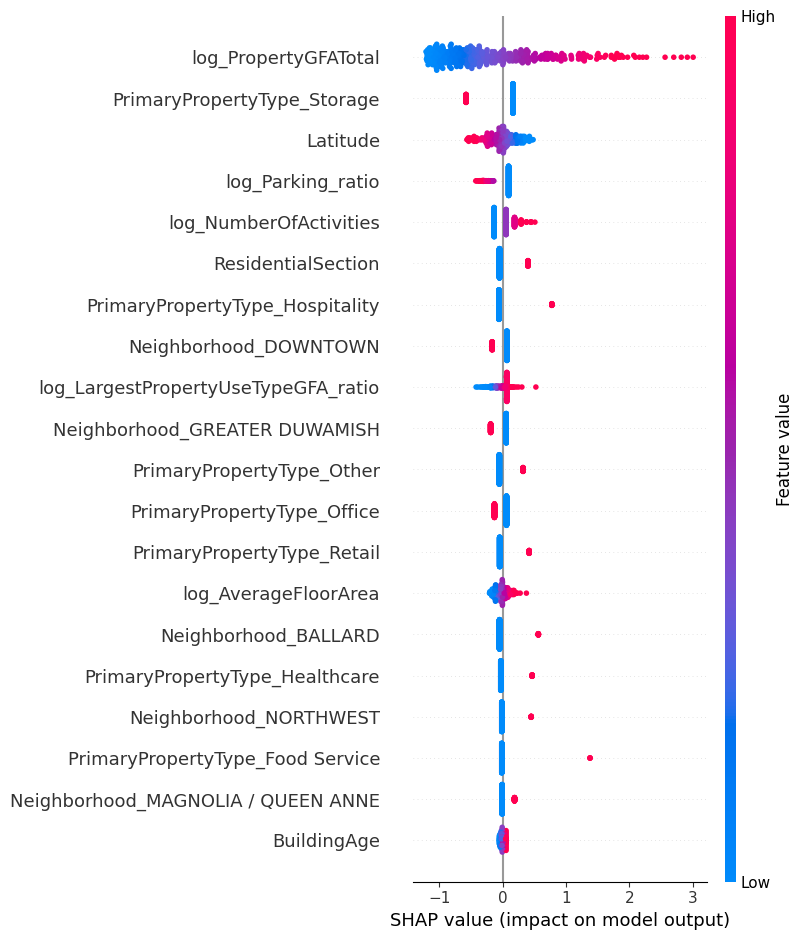

In [141]:
# Génération du résumé SHAP pour l'ensemble de test
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

**En conclusion:**  

 Notre analyse des coefficients du modèle Ridge et l'interprétation SHAP ont révélé des **informations précieuses** sur les déterminants des émissions de CO2 des propriétés. La taille totale de la propriété s'est avérée être le facteur le plus influent, ce qui confirme l'importance de la superficie dans la prédiction des émissions.

**D'autres variables**, telles que le type de propriété et la latitude, ont également montré leur pertinence, indiquant que la nature et l'emplacement du bâtiment sont des facteurs significatifs. L'approche SHAP a permis de décomposer l'impact de chaque caractéristique sur les prédictions individuelles, révélant des interactions complexes et fournissant une compréhension plus profonde de la dynamique sous-jacente.

**Le graphique SHAP** a spécifiquement mis en évidence l'impact négatif de 'PropertyGFATotal' et l'impact positif de la 'Latitude' sur les prédictions de notre modèle, soulignant l'influence des conditions climatiques et de la taille des bâtiments sur les émissions de CO2.

Cette analyse approfondie nous permet de mieux appréhender les contributions relatives des différentes caractéristiques et d'identifier les leviers potentiels pour la réduction des émissions. Elle met en lumière l'importance d'une approche holistique dans la modélisation des émissions de CO2, où une multitude de facteurs, y compris les caractéristiques physiques et géographiques des bâtiments, doivent être pris en compte pour obtenir des prédictions précises et informatives.

## ENERGYSTAR Score

In [142]:
X = X.join(df_model['ENERGYSTARScore'])

In [143]:
X= X.dropna()

In [144]:
# Préparation des données avec et sans la caractéristique 'ENERGYSTARScore
best_params = random_search_ridge.best_params_

X_with_feature = X.copy()
X_without_feature = X.drop('ENERGYSTARScore', axis=1)

y = y.loc[X_with_feature.index]
X_without_feature = X_without_feature.loc[y.index]

In [145]:
# Division des données en ensembles d'entraînement et de test avec et sans la caractéristique 'ENERGYSTARScore' et nettoyage des meilleurs paramètres
X_train_with, X_test_with, y_train, y_test = train_test_split(X_with_feature, y, test_size=0.2, random_state=42)

X_train_without = X_without_feature.loc[X_train_with.index]
X_test_without = X_without_feature.loc[X_test_with.index]

cleaned_params = {param_key.split('__')[-1]: param_value for param_key, param_value in best_params.items()}

In [146]:
# Entraînement du modèle Ridge avec la caractéristique 'ENERGYSTARScore'
model_with_feature = Ridge(**cleaned_params)
model_with_feature.fit(X_train_with, y_train)

# Entraînement du modèle Ridge sans la caractéristique 'ENERGYSTARScore'
model_without_feature = Ridge(**cleaned_params)
model_without_feature.fit(X_train_without, y_train)

Ridge(alpha=7.915074397656218, max_iter=10000, solver='svd')

In [147]:
# Évaluation des modèles à l'aide de la validation croisée
score_with_feature = -cross_val_score(model_with_feature, X_train_with, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
score_without_feature = -cross_val_score(model_without_feature, X_train_without, y_train, cv=5, scoring='neg_mean_absolute_error').mean()

print(f"Score avec la caractéristique 'ENERGYSTARScore' (MAE): {score_with_feature}")
print(f"Score sans la caractéristique 'ENERGYSTARScore' (MAE): {score_without_feature}")

Score avec la caractéristique 'ENERGYSTARScore' (MAE): 0.7114909864522142
Score sans la caractéristique 'ENERGYSTARScore' (MAE): 0.7561421567521036


In [148]:
# Prédictions sur l'ensemble de test avec la caractéristique 'ENERGYSTARScore'
y_pred_with = model_with_feature.predict(X_test_with)

# Prédictions sur l'ensemble de test sans la caractéristique 'ENERGYSTARScore'
y_pred_without = model_without_feature.predict(X_test_without)

In [149]:
# Calcul du RMSE & R² pour le modèle avec ou sans la caractéristique 'ENERGYSTARScore'
rmse_with_feature = np.sqrt(mean_squared_error(y_test, y_pred_with))
rmse_without_feature = np.sqrt(mean_squared_error(y_test, y_pred_without))

r2_with_feature = r2_score(y_test, y_pred_with)
r2_without_feature = r2_score(y_test, y_pred_without)

print(f"RMSE avec la caractéristique 'ENERGYSTARScore': {rmse_with_feature}")
print(f"RMSE sans la caractéristique 'ENERGYSTARScore': {rmse_without_feature}")
print(f"R² avec la caractéristique 'ENERGYSTARScore': {r2_with_feature}")
print(f"R² sans la caractéristique 'ENERGYSTARScore': {r2_without_feature}")

RMSE avec la caractéristique 'ENERGYSTARScore': 0.8274217432399618
RMSE sans la caractéristique 'ENERGYSTARScore': 0.9293383528582524
R² avec la caractéristique 'ENERGYSTARScore': 0.6245284558420938
R² sans la caractéristique 'ENERGYSTARScore': 0.5263354405943456


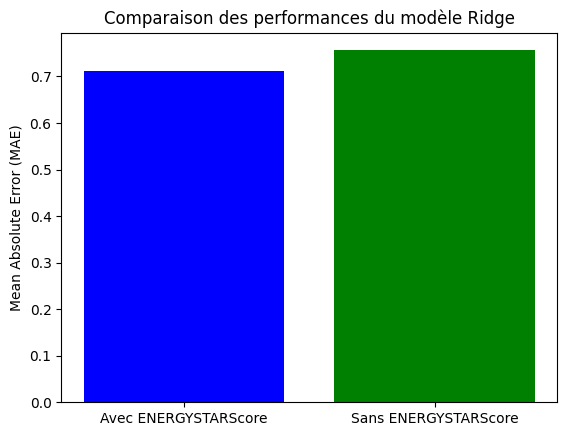

In [150]:
# Visualisation des résultats pour comparer les scores MAE
labels = ['Avec ENERGYSTARScore', 'Sans ENERGYSTARScore']
scores = [score_with_feature, score_without_feature]

plt.bar(labels, scores, color=['blue', 'green'])
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Comparaison des performances du modèle Ridge')
plt.show()

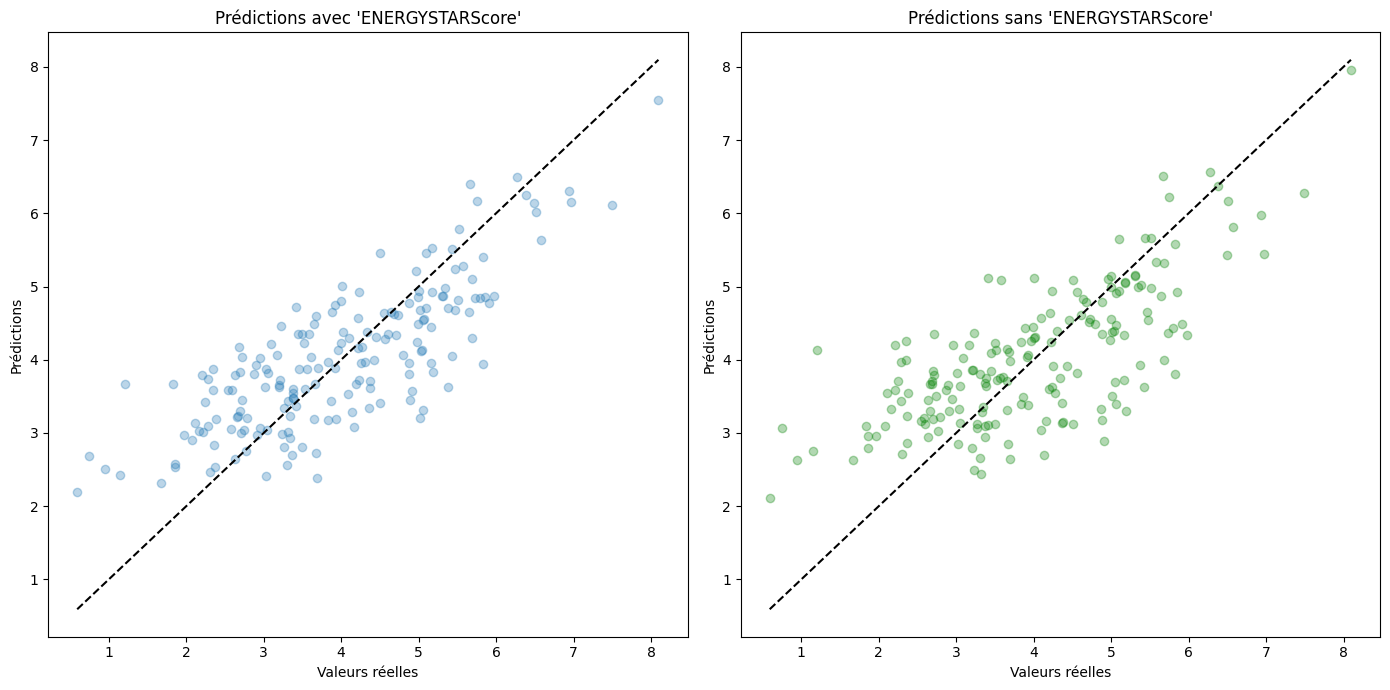

In [152]:
# Tracé des prédictions avec la caractéristique 'ENERGYSTARScore'
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_with, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')
plt.title("Prédictions avec 'ENERGYSTARScore'")
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')

# Tracé des prédictions sans la caractéristique 'ENERGYSTARScore'
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_without, alpha=0.3, color='g')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k')
plt.title("Prédictions sans 'ENERGYSTARScore'")
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')

plt.tight_layout()
plt.show()

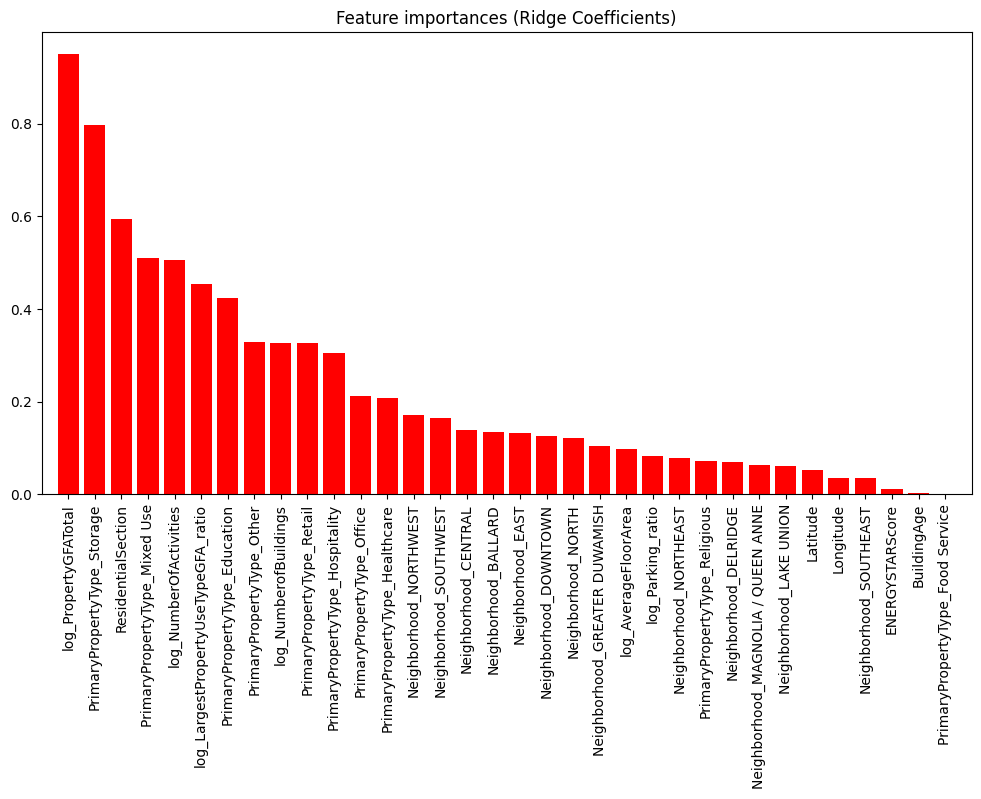

In [153]:
# Visualisation des importances des caractéristiques pour le modèle Ridge
ridge_coefficients = model_with_feature.coef_

feature_names = X_train_with.columns

importances = np.abs(ridge_coefficients)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature importances (Ridge Coefficients)")
plt.bar(range(X_train_with.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train_with.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X_train_with.shape[1]])
plt.show()

**En conclusion:**  

**L'impact de l'ENERGYSTAR Score** sur notre modèle de prédiction des émissions de CO2 confirme **son rôle bénéfique** en tant qu'indicateur de performance énergétique.  
Bien que son inclusion ait amélioré la précision des prédictions, comme en témoigne la réduction de l'erreur absolue moyenne, il n'émerge pas comme l'une des variables les plus influentes.

**Cette observation est en accord avec nos analyses antérieures**, qui ont montré que l'ENERGYSTARScore, tout en étant un élément précieux, ne doit pas être considéré isolément. Pour obtenir des modèles prédictifs robustes et précis, il est essentiel de le combiner avec d'autres variables significatives qui capturent la complexité des facteurs influençant les émissions de CO2 des bâtiments.

**La constance des résultats** à travers différents modèles renforce la notion que l'ENERGYSTARScore est un composant utile mais non suffisant pour une prédiction complète.